In [14]:
!pip3 install --user opencv-python

In [15]:
from itertools import product
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as skio
from PIL import Image

# Input images

In [82]:
data = Path("data")
out_dir = Path("output")
out_dir.mkdir(parents=True, exist_ok=True)

In [83]:
images_low_res = list(data.glob("*.jpg"))
print(f"number of images = {len(images_low_res)}")

number of images = 3


In [84]:
images_high_res = list(data.glob("*.tif"))
print(f"number of images = {len(images_high_res)}")

number of images = 11


# Aligning Channels

## Helper Functions

In [70]:
def channel_height(im):
    return im.shape[0] // 3


def channel_width(im):
    return im.shape[1]


def channels(B_start, G_start, R_start, h, w):
    # create channel matrices
    # print(B_start, G_start, R_start, h, w)
    B_mat = im[B_start : B_start + h, :w]
    G_mat = im[G_start : G_start + h, :w]
    R_mat = im[R_start : R_start + h, :w]
    return R_mat, G_mat, B_mat

In [71]:
# returns a sub_matrix extracted from IM
def sub_image(im, start, r_offset=0, c_offset=0, pad_val: float = np.inf):
    # initialize entries of result to 'inf'
    h, w = channel_height(im), channel_width(im)
    result = np.full((h - 2 * r_offset, w - 2 * c_offset), pad_val)

    # extract sub_matrix from IM
    a = im[
        start + r_offset : start + h - r_offset,
        0 + c_offset : 0 + w - c_offset,
    ]
    result[: a.shape[0], : a.shape[1]] = a
    return result

In [57]:
# Returns row displacements of G and R channels using the chosen algorithm
def align_with(im, algorithm, *args):
    # algorithm can be align_basic, align_ssd, align_ncc
    # refer to each algorithm for corresponding *args
    return algorithm(im, *args)

In [ ]:
def save_n_display(images, out_dir:Path, algorithm, *args):
    for n in range(len(images)):
        # read and display input file
        im = cv2.imread(str(images[n]), cv2.IMREAD_GRAYSCALE)
        plt.figure()
        plt.imshow(im, cmap=plt.get_cmap("gray"))

        # set channel size
        h, w = channel_height(im), channel_width(im)

        # align channels
        B_start = 0

        # G_start, R_start = align_with(im, align_basic)
        G_start, R_start = align_with(im, align_ssd)
        # G_start, R_start = pyramid(im, align_ssd)

        print(f'"The displacements are {B_start}, {G_start}, {R_start}"')
        R_mat, G_mat, B_mat = channels(B_start, G_start, R_start, h, w)
        # print(R_mat.shape, G_mat.shape, B_mat.shape)

        # combine channels and display result
        result = np.dstack([R_mat, G_mat, B_mat])
        plt.figure()
        plt.imshow(result)

        # save the images

        fname = out_dir / images_high_res[n].name
        Image.fromarray(result).save(fname)

## Alignment Algorithms

### Basic

In [34]:
# Returns alignment index by simply dividing the image in 3
def align_basic(im):
    G_start = channel_height(im)  # floor division to get integer indices
    R_start = channel_height(im) * 2
    return G_start, R_start

### SSD

In [72]:
# Returns the ssd between matrix a and matrix b
def ssd(a, b):
    return np.sum((a - b) ** 2)


# Returns row displacements that give best result
def align_ssd(
    im,
    B_start=0,
    displacement: int = 20,
    r_offset: int = 20,
    c_offset: int = 20,
):
    h, w = channel_height(im), channel_width(im)
    b = sub_image(im, B_start, r_offset, c_offset)
    G_start = h
    R_start = h * 2
    # find displacement for G channel
    score = {}
    for d in range(-displacement, displacement):
        g = sub_image(im, G_start + d, r_offset, c_offset)
        score[d] = ssd(b, g)
    G_start += min(score)
    # find displacement for R channel
    score.clear()
    for d in range(1, displacement):
        r = sub_image(im, R_start + d, r_offset, c_offset)
        score[d] = ssd(b, r)
    R_start += min(score)
    return G_start, R_start

### NCC

In [73]:
# Returns the ncc between matrix a and matrix b
def ncc(a, b):
    s = np.array([r_a @ r_b for r_a in a for r_b in b])
    return np.sum(s)


# Returns row displacements that give best result
def align_ncc(
    im,
    B_start=0,
    displacement: int = 10,
    r_offset: int = 10,
    c_offset: int = 10,
):
    h, w = channel_height(im), channel_width(im)
    b = sub_image(im, B_start, r_offset, c_offset)
    G_start = h
    R_start = h * 2
    # find displacement for G channel
    score = {}
    for d in range(-displacement, displacement):
        g = sub_image(im, G_start + d, r_offset, c_offset)
        score[d] = ncc(b, g)
    G_start += min(score)
    # find displacement for R channel
    score.clear()
    for d in range(1, displacement):
        r = sub_image(im, R_start + d, r_offset, c_offset)
        score[d] = ncc(b, r)
    R_start += min(score)
    return G_start, R_start

## Image Pyramid

In [78]:
def pyramid(im, align_metric, *args):
    if im.size < 1500 * 500:
        return align_metric(im, *args)
    im_resize = cv2.resize(im, (im.shape[0] // 2, im.shape[1] // 2))
    g_est, r_est = pyramid(im_resize, align_metric, *args)
    g = int(np.round(g_est / im_resize.shape[0] * im.shape[0]))
    r = int(np.round(r_est / im_resize.shape[0] * im.shape[0]))
    return g, r

## Alignment Results

# Adjustments

## Normalize Exposures

In [54]:
# takes in a matrix with values within [1,0],
# and transforms it so that the minimum value becomes 0, maximum value becomes 1
def fix_exposure(mat):
    unit_len = np.max(mat) - np.min(mat)
    mat = (mat - np.amin(mat)) / unit_len

In [55]:
def find_border(mat, axis):
    # zero pad mat at rightmost and bottom
    mat_padded = np.pad(mat, ((0, 1), (0, 1), "constant", 0))

    # find row border
    for i in range[mat.shape[0]]:
        val[i, i + 1] = mat_padded[i] @ mat_padded[i + 1]
    np.max(val)
    # find col border

    np.pad(mat)


def crop_borders(mat):
    find_border(mat)

In [56]:
def adjust(mat, channel_h, channel_w):
    fix_exposure(mat)
    crop_borders(mat, channel_h, channel_w)

# Test and Display Results

## Testing low resolution images

"The displacements are 0, 341, 682"
"The displacements are 0, 341, 682"
"The displacements are 0, 341, 682"


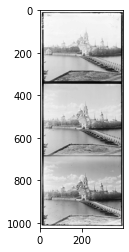

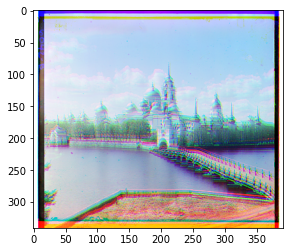

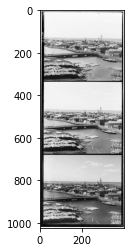

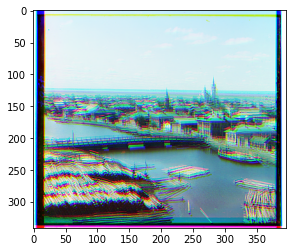

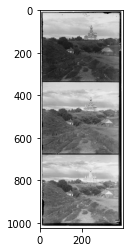

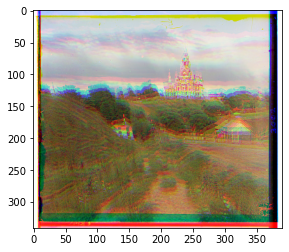

In [81]:
num_imgs = 3
for n in range(num_imgs):
    # read and display input file
    im = cv2.imread(str(images_low_res[n]), cv2.IMREAD_GRAYSCALE)
    plt.figure()
    plt.imshow(im, cmap=plt.get_cmap("gray"))

    # set channel size
    h, w = channel_height(im), channel_width(im)

    # align channels
    B_start = 0

    G_start, R_start = align_with(im, align_basic)
    # G_start, R_start = align_with(im, align_ssd)
    # G_start, R_start = pyramid(im, align_ssd)

    print(f'"The displacements are {B_start}, {G_start}, {R_start}"')
    R_mat, G_mat, B_mat = channels(B_start, G_start, R_start, h, w)
    # print(R_mat.shape, G_mat.shape, B_mat.shape)

    # combine channels and display result
    result = np.dstack([R_mat, G_mat, B_mat])
    plt.figure()
    plt.imshow(result)

    # save the images

    fname = out_dir / images_low_res[n].name
    Image.fromarray(result).save(fname)

## Testing high resolution images

"The displacements are 0, 3189, 6419"


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3208 and the array at index 1 has size 3209

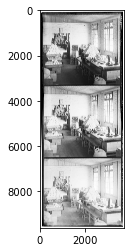

In [77]:
num_imgs = 3
for n in range(num_imgs):
    # read and display input file
    im = cv2.imread(str(images_high_res[n]), cv2.IMREAD_GRAYSCALE)
    plt.figure()
    plt.imshow(im, cmap=plt.get_cmap("gray"))

    # set channel size
    h, w = channel_height(im), channel_width(im)

    # align channels
    B_start = 0

    # G_start, R_start = align_with(im, align_basic)
    G_start, R_start = align_with(im, align_ssd)
    # G_start, R_start = pyramid(im, align_ssd)

    print(f'"The displacements are {B_start}, {G_start}, {R_start}"')
    R_mat, G_mat, B_mat = channels(B_start, G_start, R_start, h, w)
    # print(R_mat.shape, G_mat.shape, B_mat.shape)

    # combine channels and display result
    result = np.dstack([R_mat, G_mat, B_mat])
    plt.figure()
    plt.imshow(result)

    # save the images

    fname = out_dir / images_high_res[n].name
    Image.fromarray(result).save(fname)